# Homework 4 - time series forecasting

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Dataset preparation

In [15]:
data = pd.read_csv('wisla.csv')
data.head()

,stationid,name,water,hyear,hmonth,day,level,month
0,149180140,WISŁA,Wisła (2),1981,1,1,114,11
1,149180140,WISŁA,Wisła (2),1981,1,2,114,11
2,149180140,WISŁA,Wisła (2),1981,1,3,114,11
3,149180140,WISŁA,Wisła (2),1981,1,4,114,11
4,149180140,WISŁA,Wisła (2),1981,1,5,113,11


I combine the year, month and day of the measurment into one feature `date`, which will simplify the futher modelling.

In [17]:
data.rename(columns={'hyear': 'year'}, inplace=True)
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

I decided to investigate the monthly time-series forecasting, therefore for each month I extract the mean value of the water level in Vistula river.

In [ ]:
df = data[['date', 'level']].set_index('date')
monthly_df = df.resample('M').mean()

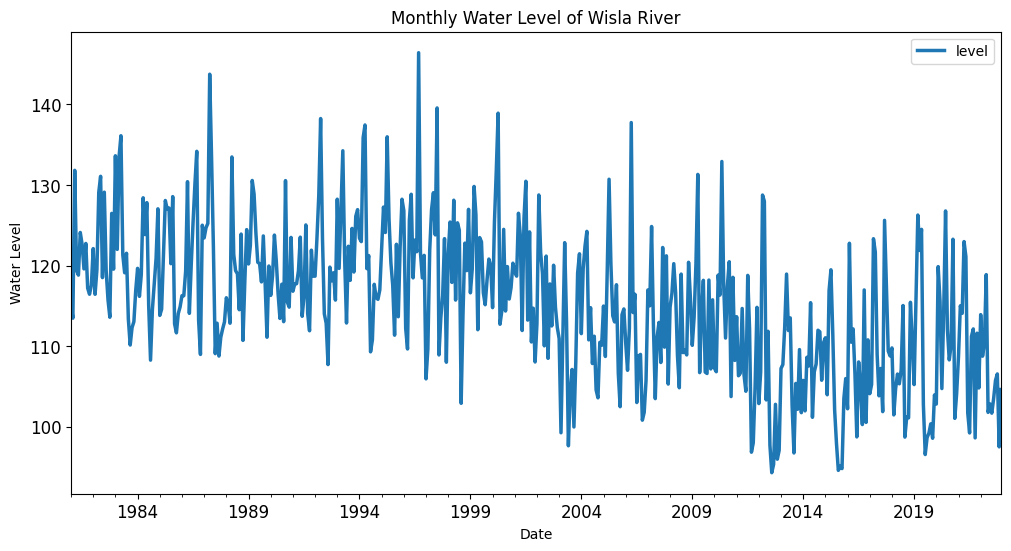

In [31]:
monthly_df.plot(figsize=(12, 6), linewidth=2.5, fontsize=12)
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Monthly Water Level of Wisla River')
plt.show()

# Trend and seasonality

## Additive model

In the additive model, the time series (Y) is assumed to be the sum of the three components:
$Y = T + S + R$
where:

1. Y is the observed time series value
2. T is the trend component and it represents the long-term pattern or direction of the time series. 
3. S is the seasonality component, which captures the regular, periodic fluctuations in the time series
5. R is the residual component and represents the remaining part of the time series after removing the trend and seasonality, capturing random fluctuations

In [52]:
series = pd.Series(monthly_df['level'], index=monthly_df.index)
result = seasonal_decompose(series, model='additive')

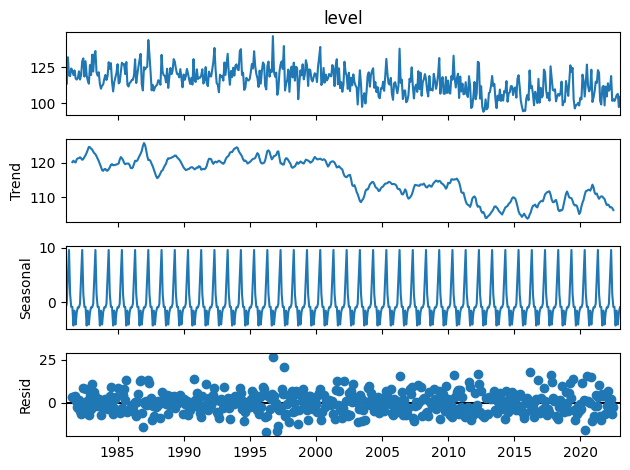

In [60]:
result.plot()
plt.show()

1. Trend: Over the period from 1981 to 2024, there is a definite decreasing trend observed in the water levels. Theobservation is validated by examining the 12-month rolling mean of the water level data, which shows a clear downward trajectory when calculated over the moving window of 12 months.

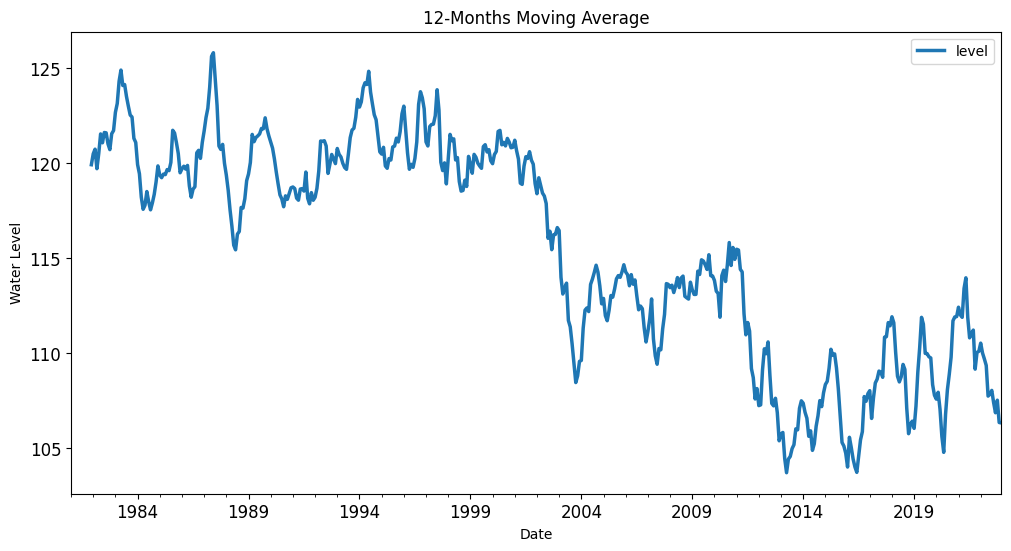

In [57]:
monthly_df.rolling(window=12).mean().plot(figsize=(12, 6), linewidth=2.5, fontsize=12)
plt.title('12-Months Moving Average')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.show()

2. Seasonality: We can notice that the additive model identified some regularities within 12-month time intervals, which overall makes a lot of sense, as they fit into the natural annual cycle.
I further investigate the seasonality factor, looking closer at years 2010-2011. As we can see, the biggest spike appears in April, when the winter snows melt and the potential of high water level in river is 

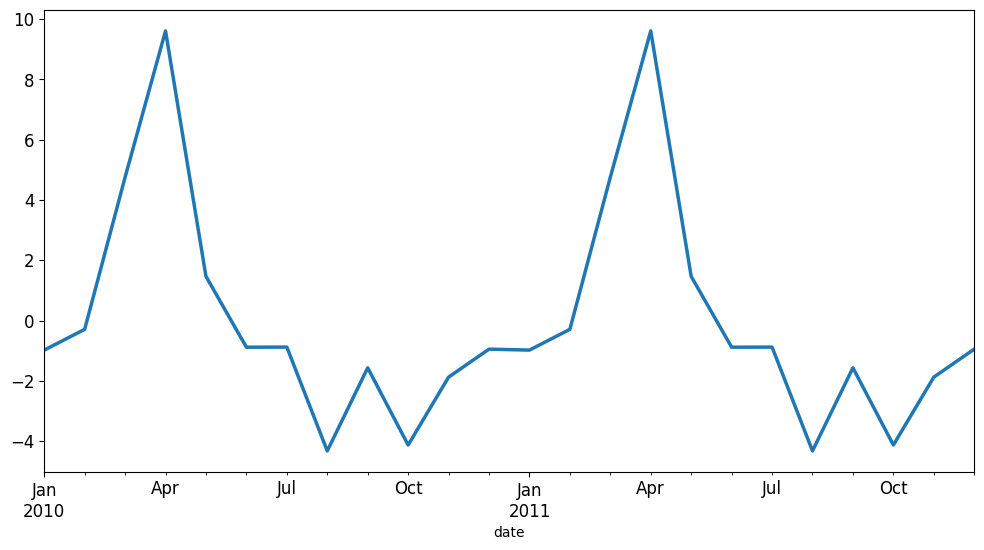

In [54]:
result.seasonal['2010-01-31':'2011-12-31'].plot(figsize=(12, 6), linewidth=2.5, fontsize=12)
plt.show()

# Seasonality

<Axes: xlabel='date'>

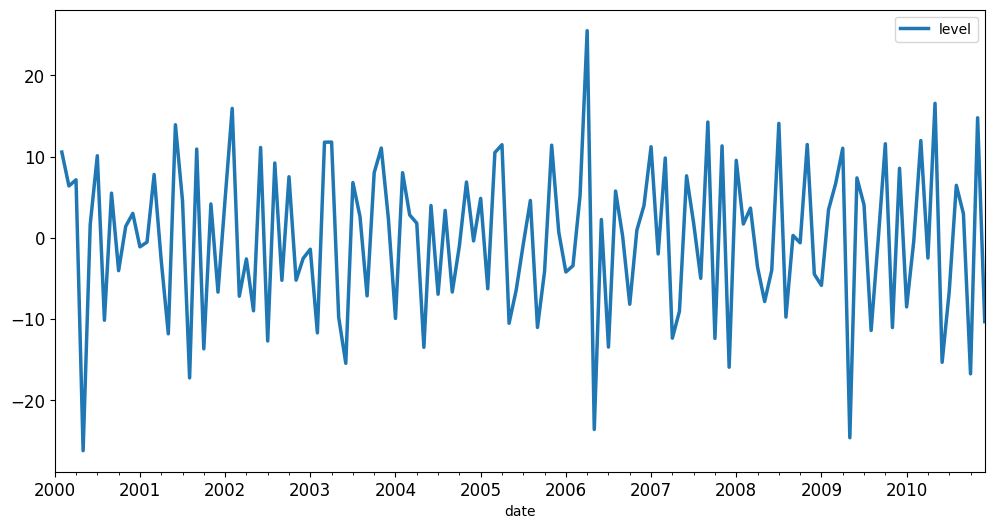

In [34]:
# choose months for years from 2000 to 2010
monthly_df['2000':'2010'].diff().plot(figsize=(12, 6), linewidth=2.5, fontsize=12)
# monthly_df.diff().plot(figsize=(12, 6), linewidth=2.5, fontsize=12)

In [ ]:
# Check stationarity using the Augmented Dickey-Fuller test
result = adfuller(monthly_data['level'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Fit the best ARMA model
best_aic = np.inf
best_order = None
best_model = None

for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(monthly_data['level'], order=(p, 0, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, 0, q)
                best_model = results
        except:
            continue

print('Best ARMA Model Order:', best_order)
print('Best AIC:', best_aic)

# Perform 1-lag ahead forecast for the entire time period
forecast = best_model.forecast(steps=len(monthly_data))

# Plot the actual data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['level'], label='Actual')
plt.plot(forecast, label='Forecast')
plt.title('Water Level of River Wisła - Actual vs. Forecast')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.legend()
plt.show()

# Identify major departures from the forecast
residuals = monthly_data['level'] - forecast
threshold = 2 * residuals.std()
departures = residuals[abs(residuals) > threshold]
print('Major Departures:')
print(departures)